In [403]:
import findspark
findspark.init()

In [404]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("test spark").getOrCreate()
sc =spark.sparkContext


In [405]:
import pyspark
import seaborn as sns

In [406]:
from pyspark.sql import SparkSession
# importing the required libraries for normalization
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


In [407]:
import pandas as pd
import numpy as np
import findspark
findspark.init()

In [408]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkSession.builder.getOrCreate()
sql = SQLContext(sc)

C:\spark3\python\pyspark\sql\context.py:112: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [409]:
import pandas as pd
import datetime

In [410]:
#Importing the dataset

df = pd.read_excel("Online Retail.xlsx")

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Inference: The Datset consists of 8 features & 541909 samples.


In [411]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [412]:
df['CustomerID'].isna().sum()

135080

- we have 135080 customers with no ids this will effect grouping so we gonna drop them

In [413]:
df = df[df['CustomerID'].isna() == False]

In [414]:
#Creating MRF Table Strategy

df_s = df
df_s["InvoiceDate"] = df_s["InvoiceDate"].dt.date
df_s["TotalSum"] = df_s["Quantity"] * df_s["UnitPrice"]
snapshot_date = max(df_s.InvoiceDate) + datetime.timedelta(days=1)
customers = df_s.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,'InvoiceNo': 'count','TotalSum': 'sum'})
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency','TotalSum': 'MonetaryValue'}, inplace=True)
#customers = customers[customers.MonetaryValue>0]
display(customers.head())

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


In [415]:
print(type(customers))

<class 'pandas.core.frame.DataFrame'>


In [416]:
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)
#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(customers) 
sparkDF.printSchema()
sparkDF.show()

root
 |-- Recency: long (nullable = true)
 |-- Frequency: long (nullable = true)
 |-- MonetaryValue: double (nullable = true)

+-------+---------+-------------+
|Recency|Frequency|MonetaryValue|
+-------+---------+-------------+
|    326|        2|          0.0|
|      3|      182|       4310.0|
|     76|       31|      1797.24|
|     19|       73|      1757.55|
|    311|       17|        334.4|
|     37|       95|      1545.41|
|    205|        4|         89.0|
|    233|       58|       1079.4|
|    215|       13|        459.4|
|     23|       59|      2811.43|
|     34|      131|      6207.67|
|      2|       19|      1168.06|
|      8|      254|      6245.53|
|     53|      129|      2662.06|
|    288|       10|        189.9|
|      4|      274|      5154.58|
|    110|       23|        552.0|
|      8|       85|       1313.1|
|    292|       23|       320.69|
|      5|       11|        168.9|
+-------+---------+-------------+
only showing top 20 rows



# 2. Features Distributions

In [417]:
#!pip install pyspark_dist_explore

Text(0.5, 0, 'Number of Customers')

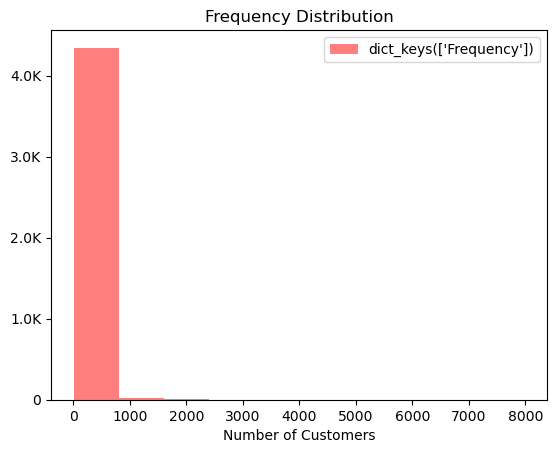

In [418]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, sparkDF.select('Frequency'), color=['red'], alpha=0.5)
plt.legend()
plt.title('Frequency Distribution')
plt.xlabel('Number of Customers')

Text(0.5, 0, 'Number of Customers')

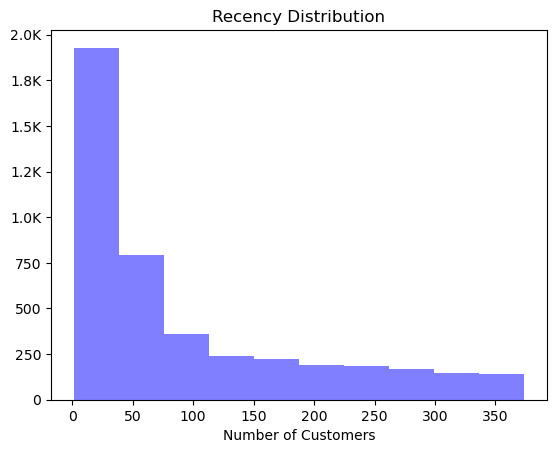

In [419]:
fig, ax = plt.subplots()
hist(ax, sparkDF.select('Recency'), color=['blue'], alpha=0.5)
plt.title('Recency Distribution')
plt.xlabel('Number of Customers')

Text(0.5, 0, 'Number of Customers')

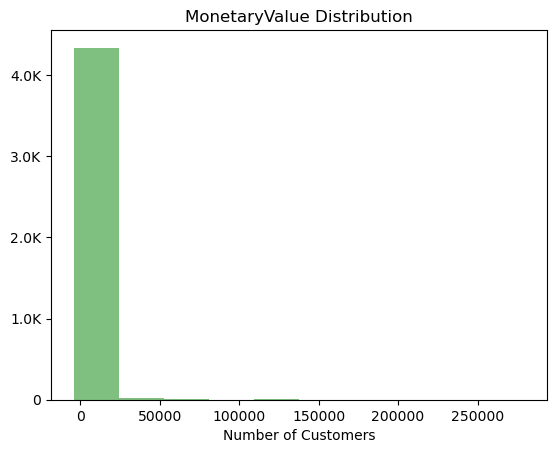

In [420]:
fig, ax = plt.subplots()
hist(ax, sparkDF.select('MonetaryValue'), color=['green'], alpha=0.5)
plt.title('MonetaryValue Distribution')
plt.xlabel('Number of Customers')

<AxesSubplot: >

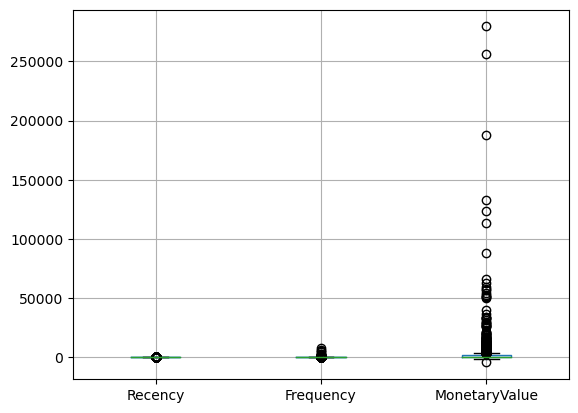

In [421]:
sparkDF.toPandas().boxplot(['Recency', 'Frequency', 'MonetaryValue'])

- From prvious chart we can found that there are negtiv `MonetaryValue` which indcated data entryerror as it's only 50 record so we gonna drop it

In [422]:
sparkDF.toPandas()[sparkDF.toPandas()['MonetaryValue'] <= 0].count()

Recency          50
Frequency        50
MonetaryValue    50
dtype: int64

In [423]:
sparkDF.toPandas()[sparkDF.toPandas()['MonetaryValue'] <= 0].head() #show some negtive values of `MonetaryValue`

,Recency,Frequency,MonetaryValue
0,326,2,0.00
125,338,1,-1126.00
127,302,1,-4.50
212,366,3,-7.50
264,360,2,-227.44


In [424]:
sparkDF = spark.createDataFrame(sparkDF.toPandas()[sparkDF.toPandas()['MonetaryValue'] >= 0]) # filtering rows with `MonetaryValue` greater than or equal to o

In [425]:
sparkDF.toPandas()[sparkDF.toPandas()['MonetaryValue'] < 0].count() # printing rows with `MonetaryValue` less than 0

Recency          0
Frequency        0
MonetaryValue    0
dtype: int64

# 2. Scaling

In [426]:
columns = sparkDF.columns # getting datafame column names

In [427]:
columns

['Recency', 'Frequency', 'MonetaryValue']

In [428]:
vec_assembler = VectorAssembler(inputCols = columns, outputCol='features') # define a matrix with three column

In [429]:
data_in_matrix = vec_assembler.transform(sparkDF) # transform the data to the matrix form

In [430]:
scaler = StandardScaler(inputCol="features", outputCol="ScaledFeatures").fit(data_in_matrix) # define a scalar object using the data

In [431]:
scaled_data = scaler.transform(data_in_matrix) # scale the data using standard scaler

In [432]:
scaled_data.show()

+-------+---------+-------------+--------------------+--------------------+
|Recency|Frequency|MonetaryValue|            features|      ScaledFeatures|
+-------+---------+-------------+--------------------+--------------------+
|    326|        2|          0.0|     [326.0,2.0,0.0]|[3.28864105817699...|
|      3|      182|       4310.0|  [3.0,182.0,4310.0]|[0.03026356802003...|
|     76|       31|      1797.24| [76.0,31.0,1797.24]|[0.76667705650751...|
|     19|       73|      1757.55| [19.0,73.0,1757.55]|[0.19166926412687...|
|    311|       17|        334.4|  [311.0,17.0,334.4]|[3.13732321807682...|
|     37|       95|      1545.41| [37.0,95.0,1545.41]|[0.37325067224708...|
|    205|        4|         89.0|    [205.0,4.0,89.0]|[2.06801048136896...|
|    233|       58|       1079.4| [233.0,58.0,1079.4]|[2.35047044955594...|
|    215|       13|        459.4|  [215.0,13.0,459.4]|[2.16888904143574...|
|     23|       59|      2811.43| [23.0,59.0,2811.43]|[0.23202068815359...|
|     34|   

- The Third column shows the data in vector form and the fourth column shows the scaled data in vector form

In [433]:
scaled_data.toPandas().head()

,Recency,Frequency,MonetaryValue,features,ScaledFeatures
0,326,2,0.00,"[326.0, 2.0, 0.0]","[3.2886410581769927, 0.008567711958295188, 0.0]"
1,3,182,4310.00,"[3.0, 182.0, 4310.0]","[0.030263568020033674, 0.7796617882048621, 0.5..."
2,76,31,1797.24,"[76.0, 31.0, 1797.24]","[0.7666770565075198, 0.13279953535357542, 0.21..."
3,19,73,1757.55,"[19.0, 73.0, 1757.55]","[0.19166926412687996, 0.31272148647777437, 0.2..."
4,311,17,334.40,"[311.0, 17.0, 334.4]","[3.1373232180768245, 0.0728255516455091, 0.040..."


# 3. Modelling 

In [434]:
final_op_df = scaled_data.toPandas()

## 3.1 RFM Segmentation

In [435]:
# Here we add 3 new columns (recency_score,Frequency_score,MonetaryValue_score) 
#recency_score
recency_score = []
recency_max = max(final_op_df.Recency)
for i in range (len(final_op_df.Recency)) :
    if final_op_df.Recency[i] >= 139 : 
        recency_score.append(1)
    elif final_op_df.Recency[i] < 139 and final_op_df.Recency[i] >= 50 :recency_score.append(2)
    elif final_op_df.Recency[i] < 50 and final_op_df.Recency[i] >= 17 :recency_score.append(3)
    else :recency_score.append(4)
final_op_df ["recency_score"]  = recency_score

#Frequency_score
Frequency_score = []
Frequency_max = max(final_op_df.Frequency)
for i in range (len(final_op_df.Frequency)) :
    if final_op_df.Frequency[i] >= 102 : Frequency_score.append(4)
    elif final_op_df.Frequency[i] < 102 and final_op_df.Frequency[i] >= 42 :Frequency_score.append(3)
    elif final_op_df.Frequency[i] < 42 and final_op_df.Frequency[i] >= 18 :Frequency_score.append(2)
    else :Frequency_score.append(1)
final_op_df ["Frequency_score"]  = Frequency_score

#MonetaryValue_score
MonetaryValue_score = []
MonetaryValue_max = max(final_op_df.MonetaryValue)
for i in range (len(final_op_df.MonetaryValue)) :
    if final_op_df.MonetaryValue[i] >= 1617 : MonetaryValue_score.append(4)
    elif final_op_df.MonetaryValue[i] < 1617 and final_op_df.MonetaryValue[i] >= 654 :MonetaryValue_score.append(3)
    elif final_op_df.MonetaryValue[i] < 654 and final_op_df.MonetaryValue[i] >= 300 :MonetaryValue_score.append(2)
    else :MonetaryValue_score.append(1)
final_op_df ["MonetaryValue_score"]  = MonetaryValue_score

In [436]:
final_op_df['MonetaryValue_score'].unique()

array([1, 4, 2, 3], dtype=int64)

In [437]:
# concatenate the 3 columns we made (recency_score,Frequency_score,MonetaryValue_score) to get RFM_Score column
final_op_df["RFM_Score"] = pd.concat([final_op_df.MonetaryValue_score.astype(str)+final_op_df.Frequency_score.astype(str)+final_op_df.recency_score.astype(str)])
final_op_df.head()

,Recency,Frequency,MonetaryValue,features,ScaledFeatures,recency_score,Frequency_score,MonetaryValue_score,RFM_Score
0,326,2,0.00,"[326.0, 2.0, 0.0]","[3.2886410581769927, 0.008567711958295188, 0.0]",1,1,1,111
1,3,182,4310.00,"[3.0, 182.0, 4310.0]","[0.030263568020033674, 0.7796617882048621, 0.5...",4,4,4,444
2,76,31,1797.24,"[76.0, 31.0, 1797.24]","[0.7666770565075198, 0.13279953535357542, 0.21...",2,2,4,422
3,19,73,1757.55,"[19.0, 73.0, 1757.55]","[0.19166926412687996, 0.31272148647777437, 0.2...",3,3,4,433
4,311,17,334.40,"[311.0, 17.0, 334.4]","[3.1373232180768245, 0.0728255516455091, 0.040...",1,1,2,211


In [438]:
#convert RFM_Score values to integer so we can sort it 
final_op_df.RFM_Score = final_op_df.RFM_Score.astype(int)
final_op_df=final_op_df.sort_values(by=['RFM_Score'],ascending=False)

In [439]:
final_op_df.head()

,Recency,Frequency,MonetaryValue,features,ScaledFeatures,recency_score,Frequency_score,MonetaryValue_score,RFM_Score
694,3,224,4404.44,"[3.0, 224.0, 4404.44]","[0.030263568020033674, 0.9595837393290612, 0.5...",4,4,4,444
1752,10,216,9451.54,"[10.0, 216.0, 9451.54]","[0.10087856006677892, 0.9253128914958804, 1.14...",4,4,4,444
1770,5,102,1625.97,"[5.0, 102.0, 1625.97]","[0.05043928003338946, 0.4369533098730546, 0.19...",4,4,4,444
2221,9,137,2213.11,"[9.0, 137.0, 2213.11]","[0.09079070406010102, 0.5868882691432205, 0.26...",4,4,4,444
4064,5,696,4204.10,"[5.0, 696.0, 4204.1]","[0.05043928003338946, 2.9815637614867256, 0.50...",4,4,4,444


In [440]:
final_op_df.describe()

,Recency,Frequency,MonetaryValue,recency_score,Frequency_score,MonetaryValue_score,RFM_Score
count,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000
mean,90.880139,93.902309,1919.929551,2.487529,2.511778,2.504388,278.044111
std,99.129091,233.434552,8255.902202,1.110007,1.118308,1.118568,120.949182
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,111.000000
25%,17.000000,18.000000,300.947500,1.000000,2.000000,2.000000,211.000000
50%,50.000000,42.000000,656.655000,2.000000,3.000000,3.000000,311.000000
75%,139.000000,102.000000,1624.170000,3.000000,4.000000,4.000000,411.750000
max,374.000000,7983.000000,279489.020000,4.000000,4.000000,4.000000,444.000000


In [441]:
def RFM_Final_Grouping(x):
    if x in range(411 + 1, 444 + 1):
        return 'Champion'
    elif x in range(311 + 1, 411 + 1):
        return 'Loyal'
    elif x in range(211 + 1, 311 + 1):
        return 'Potential'
    else:
        return 'Churn'
    
final_op_df['RFM_Segment_new'] = final_op_df['RFM_Score'].apply(RFM_Final_Grouping)
final_op_df

,Recency,Frequency,MonetaryValue,features,ScaledFeatures,recency_score,Frequency_score,MonetaryValue_score,RFM_Score,RFM_Segment_new
694,3,224,4404.44,"[3.0, 224.0, 4404.44]","[0.030263568020033674, 0.9595837393290612, 0.5...",4,4,4,444,Champion
1752,10,216,9451.54,"[10.0, 216.0, 9451.54]","[0.10087856006677892, 0.9253128914958804, 1.14...",4,4,4,444,Champion
1770,5,102,1625.97,"[5.0, 102.0, 1625.97]","[0.05043928003338946, 0.4369533098730546, 0.19...",4,4,4,444,Champion
2221,9,137,2213.11,"[9.0, 137.0, 2213.11]","[0.09079070406010102, 0.5868882691432205, 0.26...",4,4,4,444,Champion
4064,5,696,4204.10,"[5.0, 696.0, 4204.1]","[0.05043928003338946, 2.9815637614867256, 0.50...",4,4,4,444,Champion
...,...,...,...,...,...,...,...,...,...,...
3311,141,11,207.74,"[141.0, 11.0, 207.73999999999998]","[1.4223876969415827, 0.04712241577062354, 0.02...",1,1,1,111,Churn
1408,142,5,120.00,"[142.0, 5.0, 120.0]","[1.4324755529482607, 0.02141927989573797, 0.01...",1,1,1,111,Churn
1397,235,16,280.55,"[235.0, 16.0, 280.55]","[2.3706461615693044, 0.06854169566636151, 0.03...",1,1,1,111,Churn
1396,184,10,213.70,"[184.0, 10.0, 213.70000000000002]","[1.856165505228732, 0.04283855979147594, 0.025...",1,1,1,111,Churn


In [442]:
final_op_df.head()

,Recency,Frequency,MonetaryValue,features,ScaledFeatures,recency_score,Frequency_score,MonetaryValue_score,RFM_Score,RFM_Segment_new
694,3,224,4404.44,"[3.0, 224.0, 4404.44]","[0.030263568020033674, 0.9595837393290612, 0.5...",4,4,4,444,Champion
1752,10,216,9451.54,"[10.0, 216.0, 9451.54]","[0.10087856006677892, 0.9253128914958804, 1.14...",4,4,4,444,Champion
1770,5,102,1625.97,"[5.0, 102.0, 1625.97]","[0.05043928003338946, 0.4369533098730546, 0.19...",4,4,4,444,Champion
2221,9,137,2213.11,"[9.0, 137.0, 2213.11]","[0.09079070406010102, 0.5868882691432205, 0.26...",4,4,4,444,Champion
4064,5,696,4204.10,"[5.0, 696.0, 4204.1]","[0.05043928003338946, 2.9815637614867256, 0.50...",4,4,4,444,Champion


In [443]:
prediction_mean_rfm = final_op_df.groupby(['RFM_Segment_new']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue':'mean'})
prediction_mean_rfm['RFM_segment'] = prediction_mean_rfm.index

prediction_mean_rfm['Recency'] = prediction_mean_rfm['Recency'].apply(np.ceil).astype(int)
prediction_mean_rfm['Frequency'] = prediction_mean_rfm['Frequency'].apply(np.ceil).astype(int)
prediction_mean_rfm['MonetaryValue'] = prediction_mean_rfm['MonetaryValue'].apply(np.ceil).astype(int)
prediction_mean_rfm


,Recency,Frequency,MonetaryValue,RFM_segment
RFM_Segment_new,,,,
Champion,34,244,5984,Champion
Churn,159,17,193,Churn
Loyal,63,79,1066,Loyal
Potential,103,40,468,Potential


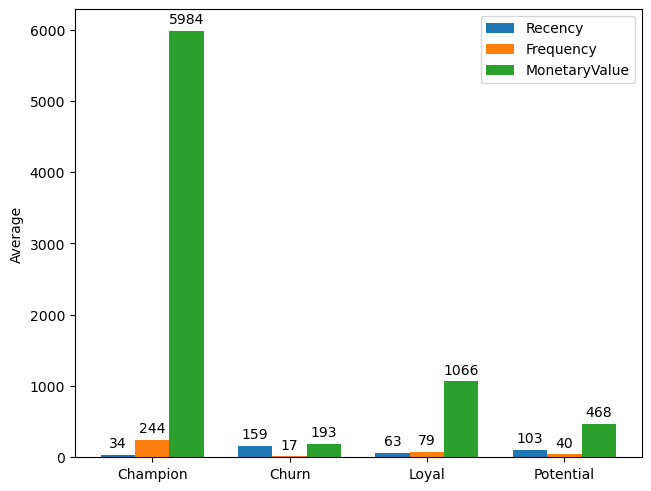

In [444]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

species = prediction_mean_rfm['RFM_segment']
penguin_means = {
    'Recency': prediction_mean_rfm['Recency'],
    'Frequency': prediction_mean_rfm['Frequency'],
    'MonetaryValue': prediction_mean_rfm['MonetaryValue'],
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylabel('Average')
plt.show()

In [445]:
RFM_segments = final_op_df.groupby(['RFM_Segment_new']).agg({'RFM_Segment_new': 'count'})
RFM_segments['RFM_segment'] = prediction_mean_rfm.index
RFM_segments

,RFM_Segment_new,RFM_segment
RFM_Segment_new,,
Champion,1083,Champion
Churn,1180,Churn
Loyal,1069,Loyal
Potential,998,Potential


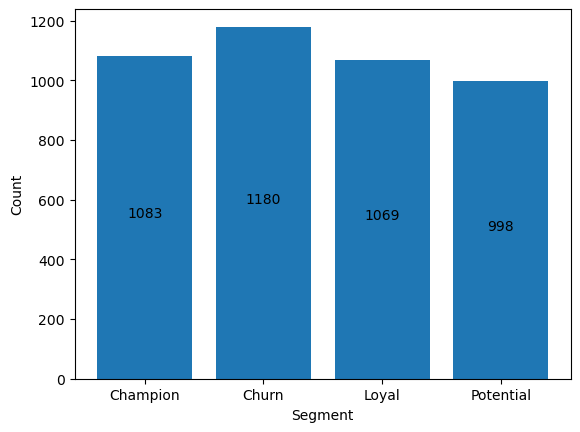

In [446]:
plt.bar(RFM_segments['RFM_segment'], RFM_segments['RFM_Segment_new'])
plt.xlabel('Segment')
plt.ylabel('Count')
pps = ax.bar(len(RFM_segments['RFM_segment']), RFM_segments['RFM_Segment_new'], 0.35, label='population')
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
addlabels(RFM_segments['RFM_segment'], RFM_segments['RFM_Segment_new'])

## 3.2 K-Means Sgmentation

In [447]:
#removing ouliers
#removing rows with frequancy>2700
#removing rows with MonetaryValue>124000

scaled_data_df = scaled_data.toPandas()
print (f"before we remove the outliers {len(scaled_data_df)}")
scaled_data_df.drop(scaled_data_df.index[(scaled_data_df["Frequency"]>2700)],axis=0,inplace=True)
scaled_data_df.drop(scaled_data_df.index[(scaled_data_df["MonetaryValue"]>123000)],axis=0,inplace=True)
print (f"after we remove the outliers {len(scaled_data_df)}")
sparkDF=spark.createDataFrame(scaled_data_df)

before we remove the outliers 4330
after we remove the outliers 4321


In [448]:
#!pip install plotly

In [449]:
#after removing ouliers
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import plotly.express as px
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='ScaledFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
# we compute Silhouette Score for each K to find the optimal k that maximize Silhouette Score
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='ScaledFeatures', k=i,seed=42)
    
    KMeans_fit=KMeans_algo.fit(sparkDF)
    
    output=KMeans_fit.transform(sparkDF)
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)
    #for poltting 3D
    df_scores = output.toPandas()
    fig = px.scatter_3d(df_scores, x='Recency', y='Frequency', z='MonetaryValue',
                  color='prediction')
    fig.show()

Silhouette Score: 0.7246200466860045


Silhouette Score: 0.7767294585635441


Silhouette Score: 0.6610058376933446


Silhouette Score: 0.7010311081404001


Silhouette Score: 0.5633873528029867


Silhouette Score: 0.589014334419228


Silhouette Score: 0.51773665351851


Silhouette Score: 0.5627794405539741


Text(0, 0.5, 'Silhouette')

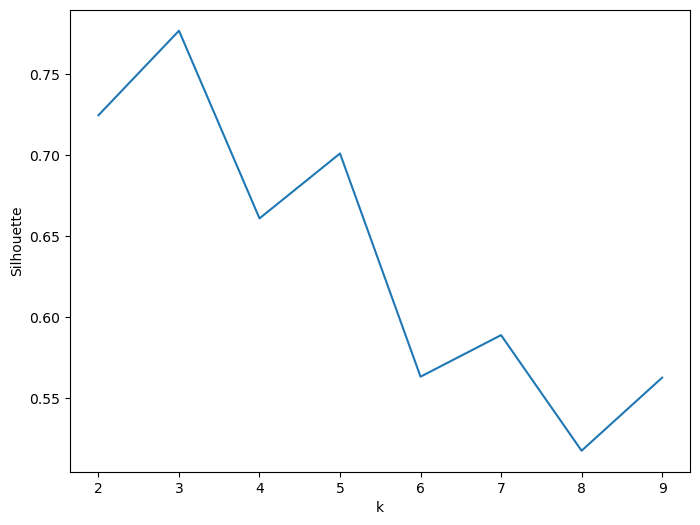

In [450]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette')

K = 3 is the best

In [451]:
# we train again with the optimal k (k=3) and get the predictions
KMeans_algo=KMeans(featuresCol='ScaledFeatures', k=3,seed=42)
    
KMeans_fit=KMeans_algo.fit(sparkDF)
    
final_op=KMeans_fit.transform(sparkDF)
score=evaluator.evaluate(final_op)
    
silhouette_score.append(score)
    
print("Silhouette Score:",score)

Silhouette Score: 0.7767294585635441


In [452]:
#getting the centroids for each cluster 
centers = KMeans_fit.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.49787115 0.12189891 0.0595636 ]
[0.43840542 0.32199073 0.15845124]
[0.1296098  2.13758991 1.38212574]


In [453]:
final_op.show()

+-------+---------+-------------+--------------------+--------------------+----------+
|Recency|Frequency|MonetaryValue|            features|      ScaledFeatures|prediction|
+-------+---------+-------------+--------------------+--------------------+----------+
|    326|        2|          0.0|     [326.0,2.0,0.0]|[3.28864105817699...|         0|
|      3|      182|       4310.0|  [3.0,182.0,4310.0]|[0.03026356802003...|         1|
|     76|       31|      1797.24| [76.0,31.0,1797.24]|[0.76667705650751...|         1|
|     19|       73|      1757.55| [19.0,73.0,1757.55]|[0.19166926412687...|         1|
|    311|       17|        334.4|  [311.0,17.0,334.4]|[3.13732321807682...|         0|
|     37|       95|      1545.41| [37.0,95.0,1545.41]|[0.37325067224708...|         1|
|    205|        4|         89.0|    [205.0,4.0,89.0]|[2.06801048136896...|         0|
|    233|       58|       1079.4| [233.0,58.0,1079.4]|[2.35047044955594...|         0|
|    215|       13|        459.4|  [215.0,1

In [454]:
final_op_df = final_op.toPandas()

In [455]:
#figure out what is the number of samples for each cluster 
zero =sum(final_op_df["prediction"]==0)
one = sum(final_op_df["prediction"]==1)
two = sum(final_op_df["prediction"]==2)
print(f"number of samples in calss 1 = {zero}")
print(f"number of samples in calss 2 = {one}")
print(f"number of samples in calss 3 = {two}")

number of samples in calss 1 = 1043
number of samples in calss 2 = 3041
number of samples in calss 3 = 237


<AxesSubplot: xlabel='MonetaryValue', ylabel='Frequency'>

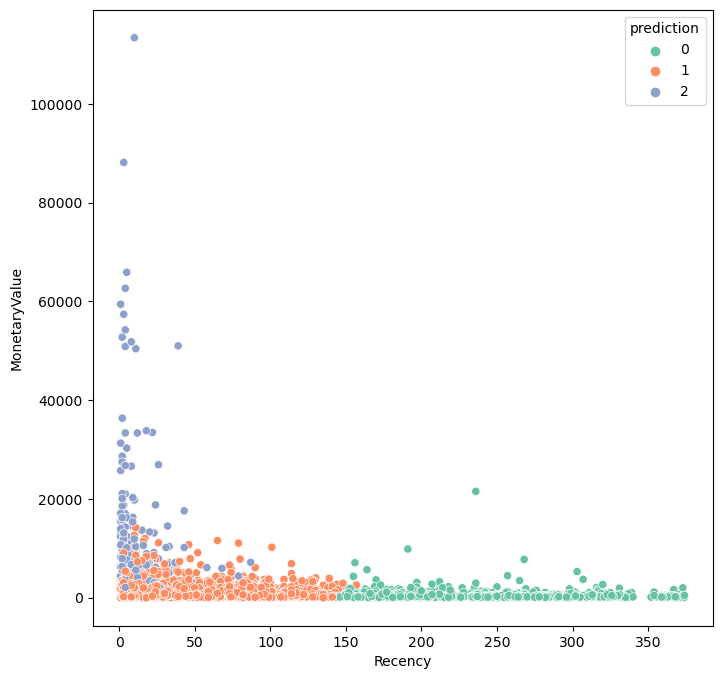

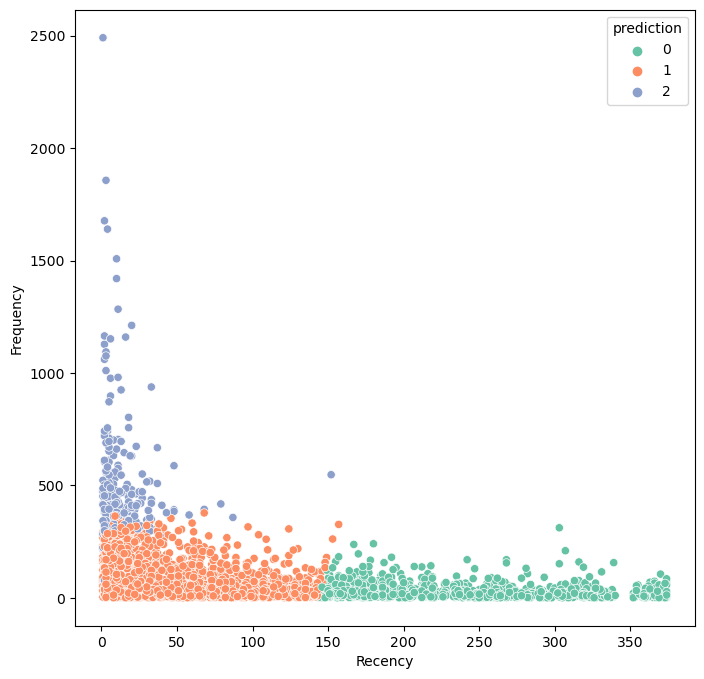

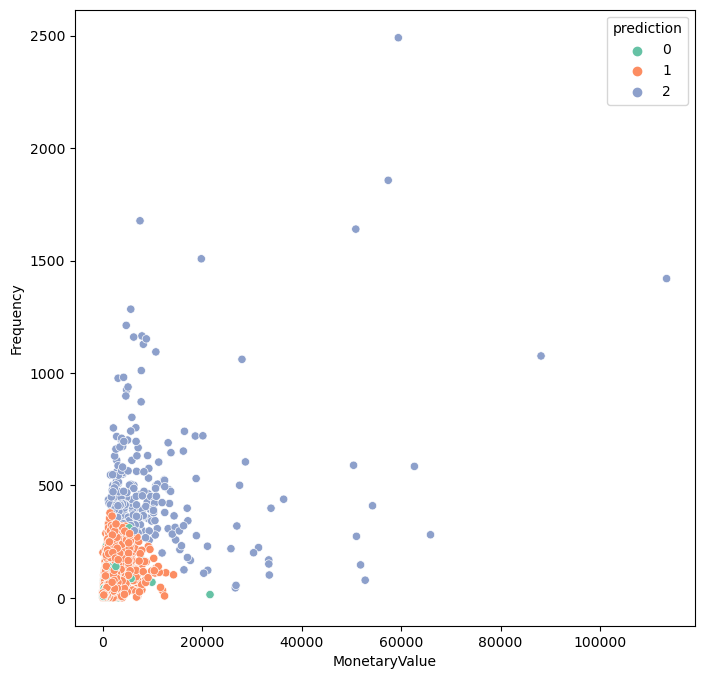

In [456]:
#plotting features against each other

selected_result_df = final_op_df#.query('Monetary < 100000').query('Frequency < 3000')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='MonetaryValue', data=selected_result_df, hue='prediction',palette="Set2")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=selected_result_df, hue='prediction',palette="Set2")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='MonetaryValue', y='Frequency', data=selected_result_df, hue='prediction',palette="Set2")

In [457]:
#converting ou output to pandas dataframe 
final_op_df=final_op.toPandas()

In [458]:
prediction_mean = final_op_df.groupby(['prediction']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue':'mean'})
prediction_mean

,Recency,Frequency,MonetaryValue
prediction,,,
0,247.611697,28.455417,491.751286
1,43.458731,75.163762,1308.157929
2,12.848101,498.987342,11410.694979


In [459]:
prediction_mean.sort_values(['MonetaryValue', 'Frequency', 'Recency'], ascending=[False, False, True], inplace=True)
prediction_mean['group_index'] = prediction_mean.index

## The table below show the averages - centrouds- of each cluster sorted Dscending by `MonetaryValue` `Frequency` and ascending by `Recency` respectively

In [460]:
prediction_mean

,Recency,Frequency,MonetaryValue,group_index
prediction,,,,
2,12.848101,498.987342,11410.694979,2
1,43.458731,75.163762,1308.157929,1
0,247.611697,28.455417,491.751286,0


In [461]:
def customer_segment(x):
    if x == 2:
        return 'Champion'
    elif x == 1:
        return 'Loyal'
    else:
        return 'Potential'

In [462]:
prediction_mean['K-means Segmentation'] = prediction_mean['group_index'].apply(customer_segment)

In [463]:
prediction_mean

,Recency,Frequency,MonetaryValue,group_index,K-means Segmentation
prediction,,,,,
2,12.848101,498.987342,11410.694979,2,Champion
1,43.458731,75.163762,1308.157929,1,Loyal
0,247.611697,28.455417,491.751286,0,Potential


In [464]:
prediction_mean['Recency'] = prediction_mean['Recency'].apply(np.ceil).astype(int)
prediction_mean['Frequency'] = prediction_mean['Frequency'].apply(np.ceil).astype(int)
prediction_mean['MonetaryValue'] = prediction_mean['MonetaryValue'].apply(np.ceil).astype(int)

In [465]:
prediction_mean

,Recency,Frequency,MonetaryValue,group_index,K-means Segmentation
prediction,,,,,
2,13,499,11411,2,Champion
1,44,76,1309,1,Loyal
0,248,29,492,0,Potential


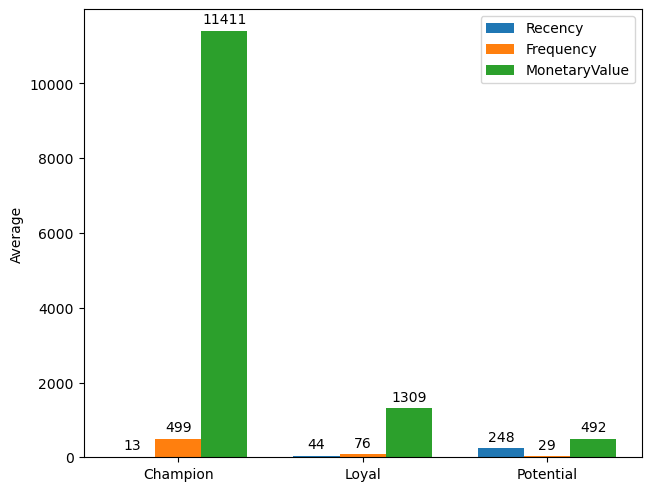

In [466]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

species = prediction_mean['K-means Segmentation']
penguin_means = {
    'Recency': prediction_mean['Recency'],
    'Frequency': prediction_mean['Frequency'],
    'MonetaryValue': prediction_mean['MonetaryValue'],
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylabel('Average')
plt.show()

In [467]:
final_op_df['K-means Segmentation'] = final_op_df['prediction'].apply(customer_segment)

In [468]:
final_op_df.rename(columns={'customer_loyalty': 'RFM Segmentation'}, inplace=True)

In [469]:
final_op_df.head()

,Recency,Frequency,MonetaryValue,features,ScaledFeatures,prediction,K-means Segmentation
0,326,2,0.00,"[326.0, 2.0, 0.0]","[3.2886410581769927, 0.008567711958295188, 0.0]",0,Potential
1,3,182,4310.00,"[3.0, 182.0, 4310.0]","[0.030263568020033674, 0.7796617882048621, 0.5...",1,Loyal
2,76,31,1797.24,"[76.0, 31.0, 1797.24]","[0.7666770565075198, 0.13279953535357542, 0.21...",1,Loyal
3,19,73,1757.55,"[19.0, 73.0, 1757.55]","[0.19166926412687996, 0.31272148647777437, 0.2...",1,Loyal
4,311,17,334.40,"[311.0, 17.0, 334.4]","[3.1373232180768245, 0.0728255516455091, 0.040...",0,Potential


In [470]:
k_means_segments = final_op_df.groupby(['K-means Segmentation']).agg({'K-means Segmentation': 'count'})
k_means_segments['Segment'] = k_means_segments.index
k_means_segments

,K-means Segmentation,Segment
K-means Segmentation,,
Champion,237,Champion
Loyal,3041,Loyal
Potential,1043,Potential


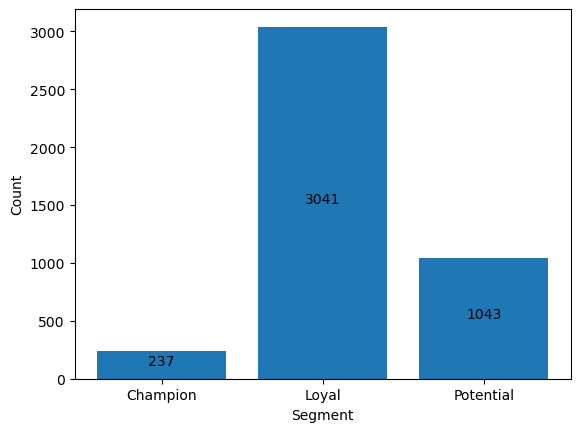

In [471]:
plt.bar(k_means_segments['Segment'], k_means_segments['K-means Segmentation'])
plt.xlabel('Segment')
plt.ylabel('Count')
pps = ax.bar(len(k_means_segments['Segment']), k_means_segments['K-means Segmentation'], 0.35, label='population')
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
addlabels(k_means_segments['Segment'], k_means_segments['K-means Segmentation'])